In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as sop
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
class csv_tag():
    def __init__(self, name, path, deform=None, time=None, center=None, velocity=None, nVol=None, nArea=None):
        self.name = name
        self.path = path
        self.deform = list() if deform is None else deform
        self.time = list() if time is None else time
        self.center = dict() if center is None else center
        self.velocity = dict() if velocity is None else velocity
        self.nVol = list() if nVol is None else nVol
        self.nArea = list() if nArea is None else nArea
    
    def analysis(self):
        # analysis velocity change in presentage
        init_Vol = self.nVol[0]
        pVol = []
        for i in self.nVol:
            temp_pVol = i/init_Vol
            pVol.append(temp_pVol)
        self.pVol = pVol

In [3]:
def float_to_str(f):
    if f == 0:
        str_out = 0
        return str_out
    else:
        if f < 0:
            sign = 'n'
        else:
            sign = ''
    f = abs(f)
    temp_float = f%1
    int_part = int(f - temp_float)
    float_part = round(f%1, 2)
    float_part = int(float_part*100)
    float_str = str(float_part)
    str_out = sign + str(int_part) + 'p' + float_str
    return str_out

In [4]:
def gene_name(axes, stiffness, coord): 
    """ 
    this function helps generate name from given cell parameters, it will take 
    axes(a float), stiffness( a float), and coord(tuble of x, y, and z), and make it a
    string to help locate the address of the folder contains cell information.  
    
    input:
        axes(float)
        stiffness(float)
        coord (tuple/list): (x, y, z)

    output:
        name(str): axes_stiffness_x_y_z use 'p' for dot and 'n' for negative
    """
    axes_str = float_to_str(axes)
    if axes_str[-1] == '0' and len(axes_str) == 4:
        axes_str = axes_str[:-1]
    stif_str = str(stiffness)
    if coord != None:
        x = float_to_str(coord[0])
        y = float_to_str(coord[1])
        z = float_to_str(coord[2])
        name = "a{}_s{}_{}_{}_{}".format(axes_str, stif_str, x, y, z)
    else:
        name = "a{}_s{}".format(axes_str, stif_str)
    return name

In [5]:
def gene_csv (path, name):
    """ generate a csv class for future use
    take the path, which contains the filename (metadata.csv)
    and output the class
    
    input:
    path(str): the address to the """
    count = 0
    name = name
    filename = "0.metadata.csv"
    for i in name:
        if i == "_":
            count += 1 
    if count == 0:
        raise ValueError('Please input information in a correct formate')
    elif count == 1:
        path = path + "vis_cell_" + name + ".iter/" + filename
    elif count == 4:
        path = path + "vis_" + name + ".iter/" + filename
    csv = csv_tag(name, path)
    return csv

In [6]:
def read_csv_metadata(axes, stiffness, coord=None):
    path = 'run/'
    name = gene_name(axes, stiffness, coord)
    csv = gene_csv(path, name)
    data = pd.read_csv('{}'.format(csv.path))
    data_sorted = data.sort_values('time')
    csv.time = data_sorted['time']
    csv.deform = data_sorted['taylorDeformation']
    csv.center['x'] = list(data_sorted['center_x'])
    csv.center['y'] = list(data_sorted['center_y'])
    csv.center['z'] = list(data_sorted['center_z'])
    csv.nVol = data_sorted['normalizedVol']
    csv.nArea = data_sorted['normalizedArea']
    return csv

In [44]:
# get the data
def plot_fitted_curve (axes, stiffness, coords=None, range_of_interest=None):
    def objective(x, a, b, c, d, e, f, g):
        return a*x + b * x**2 + c * x**3 + d * x**4 + e * x**5 + f * x**6 + g
    range_of_interest = (-155, -136) if range_of_interest is None else range_of_interest
    data=read_csv_metadata(axes, stiffness, coords) # read data
    t = data.time
    x = data.center['x']
    y = data.center['y']
    cut_x = []
    cut_y = []
    cut_t = []
    for i, xi in enumerate(x): # find the range of interest
        if xi < range_of_interest[1] and xi > range_of_interest[0]:
            cut_x.append(xi)
            cut_y.append(y[i])
            cut_t.append(t[i])

    popt, _ = sop.curve_fit(objective, cut_x, cut_y) # furve fitting and store the solved parameters
    a, b, c, d, e, f, g= popt
    para = []
    for i in popt:
        para.append(round(i, 2))

    # plot the data points and fitted line
    # plt.scatter(cut_x, cut_y)
    x_line = np.arange(min(cut_x), max(cut_x), 1)
    y_line = objective(x_line, a, b, c, d, e, f, g)
    plt.plot(x_line, y_line, '--',color = color_list[xx], label='y={}x + {}x^2 + {}x^3 + {}x^4 + {}x^5 + {}x^6 + {}'.format(para[0],para[1],para[2],para[3],para[4],para[5],para[6]))
    plt.legend()
    return 0


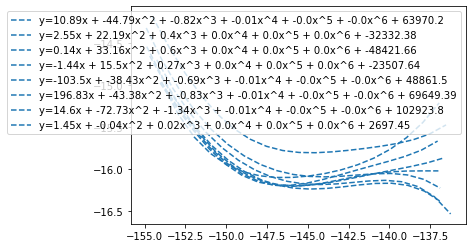

In [45]:
color_list = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
axes = [2.95]
stiffnesses = [2, 5, 10, 20, 40, 80, 120, 160]
coord = (-230, 0, 0)
xx = 0
for a in axes: 
    for s in stiffnesses:
        plot_fitted_curve(a, s, coord)
plt.show()

model = tf.keras.Sequential([
  tf.keras.layers.Dense(8, activation='sigmoid'),
  tf.keras.layers.Dense(8, activation='sigmoid'),
  tf.keras.layers.Dense(1)
])
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.1))
model.fit(cut_x,cut_y, epochs=100, verbose=False)